In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import inspect
import os
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
# Carregamento do dataset
dataset = pd.read_csv("../data/creditcard.csv")

# Converte todos os nomes de colunas para minúsculas
dataset.columns = dataset.columns.str.lower()

In [26]:
#mostra as primeiras linhas do dataset
dataset.head()


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Funções para conversão e padronização de datas
POSSIBLE_DATE_FORMATS = ['%d/%m/%Y', '%Y-%m-%d %H:%M:%S:%f', '%Y-%m-%dT%H:%M:%S.%fZ', '%Y-%m-%d']

def to_date(date):
  for date_format in POSSIBLE_DATE_FORMATS:
    try:
      return datetime.datetime.strptime(date, date_format)
    except ValueError:
      pass
    except TypeError:
      return date

def to_valid_date(date):
  try:
    # print(date)
    int_year = int(str(date)[0:4])
    if int_year > 2023:
      # print('yes')
      return np.nan
    else:
      return pd.to_datetime(date, format="%Y-%m-%d %H:%M:%S")
  except ValueError:
    return np.nan
  except TypeError:
    return np.nan 
  except pd.errors.OutOfBoundsDatetime:
    x = str(date)
    return pd.to_datetime('2020'+x[4:], format="%Y-%m-%d %H:%M:%S") 

In [ ]:
#Mostra quantas linhas e colunas existem
#Mostra o tipo de cada variável
#Diz quantos valores nulos existem
#Ajuda a entender a estrutura geral dos dados


# Informações gerais
print("Informações do dataset:")
print(dataset.info())

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null 

In [ ]:
#Gera estatísticas como:
#média
#desvio padrão
#mínimo e máximo
#percentis

# Estatísticas básicas
print("\nEstatísticas descritivas:")
print(dataset.describe())


Estatísticas descritivas:


                time            v1            v2            v3            v4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 v5            v6            v7            v8            v9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.021879e-15  1.494498e-15 -5.620335e-16  1.149614e-16 -2.414189e-15   
std    1.380247e+00  1.332271e+00  1.23709

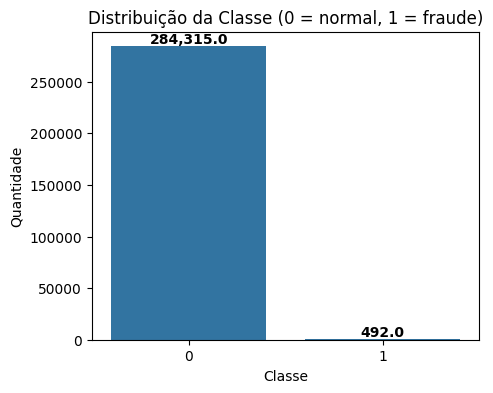

class
0    284315
1       492
Name: count, dtype: int64

Percentual de fraude:
class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


In [38]:
#Exibe um gráfico contando quantas transações são:
#0 = normal
#1 = fraude


# Distribuição da variável alvo com valores anotados
plt.figure(figsize=(5,4))
ax = sns.countplot(x=dataset['class'])

# Adiciona os valores nas barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:,}',                           # formata com separador de milhar
        (p.get_x() + p.get_width() / 2, height), # posição do texto
        ha='center', va='bottom',
        fontsize=10, fontweight='bold',
        color='black'
    )

plt.title("Distribuição da Classe (0 = normal, 1 = fraude)")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.show()

# Impressões complementares
print(dataset['class'].value_counts())
print("\nPercentual de fraude:")
print(dataset['class'].value_counts(normalize=True) * 100)

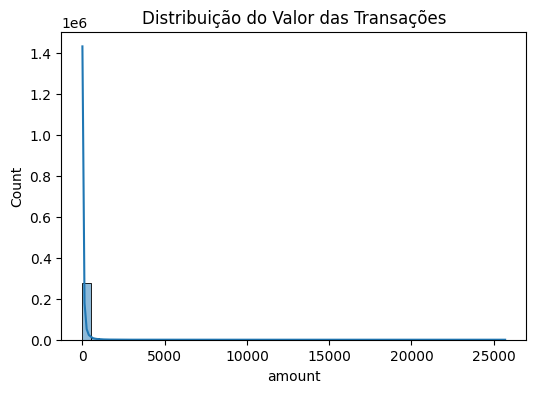

In [ ]:
#Mostra a distribuição dos valores de pagamento.
#Sendo mportante Ver se existem valores extremos
#Ver se precisamos normalizar a variável Amount
#Geralmente são valores pequenos com poucos valores muito altos

# Histograma do valor das transações
plt.figure(figsize=(6,4))
sns.histplot(dataset['amount'], bins=50, kde=True)
plt.title("Distribuição do Valor das Transações")
plt.show()

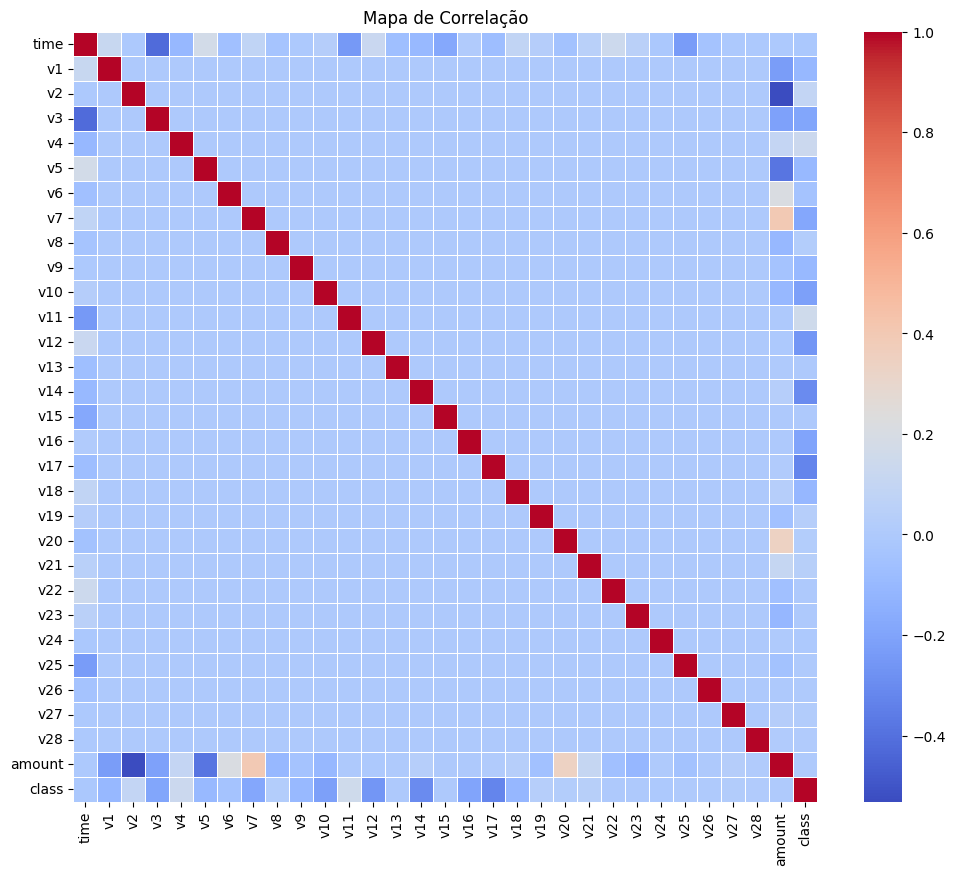

In [31]:
# Heatmap de correlação
plt.figure(figsize=(12,10))
sns.heatmap(dataset.corr(), cmap="coolwarm", linewidths=0.5)
plt.title("Mapa de Correlação")
plt.show()

In [ ]:
# ============================================================
#                PASSO 2 — PRÉ-PROCESSAMENTO
# ============================================================

# O pré-processamento prepara o dataset para que o modelo aprenda de forma correta, eliminando 
# problemas como escalas diferentes, dados extremos e desbalanceamento. No nosso caso, serão aplicados os seguintes processos:
# ============================================================

# 2.1 — Verificação de valores ausentes
# 2.2 — Tratamento de valores ausentes
# 2.3 — Normalização (padronização) das colunas "amount" e "time"
# 2.4 — Remoção de outliers
# 2.5 — Balanceamento das classes
# 2.6 — Separação final em treino e testes
# ============================================================

In [47]:
#2.1 - Verificar valores ausentes
print("Valores ausentes por coluna:")
print(dataset.isnull().sum())

Valores ausentes por coluna:
time             0
v1               0
v2               0
v3               0
v4               0
v5               0
v6               0
v7               0
v8               0
v9               0
v10              0
v11              0
v12              0
v13              0
v14              0
v15              0
v16              0
v17              0
v18              0
v19              0
v20              0
v21              0
v22              0
v23              0
v24              0
v25              0
v26              0
v27              0
v28              0
amount           0
class            0
amount_scaled    0
time_scaled      0
dtype: int64


In [ ]:
#2.2 - Remove linhas com valores ausentes (caso existam)
dataset = dataset.dropna()
print("\nApós remoção de valores ausentes:", dataset.shape)


Após remoção de valores ausentes: (284807, 31)


In [ ]:
# 2.3 — Normalização das colunas Amount e Time

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#Esse objeto calcula:
#média da coluna
#desvio padrão
#e transforma os valores usando a função z = (x - média) / desvio padrão

dataset['amount_scaled'] = scaler.fit_transform(dataset[['amount']])
#média = 0
#desvio padrão = 1
#deixam o dataset mais adequado para treinar
dataset['time_scaled']   = scaler.fit_transform(dataset[['time']])

print("\nColunas normalizadas adicionadas (amount_scaled, time_scaled).")
#Agora o dataset possui:
#amount_scaled
#time_scaled
#otal de 33 colunas agora.


Colunas normalizadas adicionadas (amount_scaled, time_scaled).


In [ ]:
# 2.4 — Remover outliers da coluna 'amount'
# O dataset tem transações com valores muito altos, removemos extremos
# usando a técnica IQR (Intervalo Inter-Quartil).
Q1 = dataset['amount'].quantile(0.25)
Q3 = dataset['amount'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

dataset = dataset[
    (dataset['amount'] >= limite_inferior) &
    (dataset['amount'] <= limite_superior)
]

print("\nApós remoção de outliers:", dataset.shape)


Após remoção de outliers: (234933, 33)


In [ ]:
#2.5 - Balanceamento das classes
# O dataset é extremamente desbalanceado (fraudes =0.17%)

from imblearn.over_sampling import SMOTE

# Separar atributos (X) e rótulo (y)
X = dataset.drop('class', axis=1)
y = dataset['class']

# O SMOTE cria novos exemplos sintéticos da classe (fraudes),
# usando interpolação entre vizinhos próximos. Isso evita overfitting e
# deixa as duas classes com o mesmo número de amostras.

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nDistribuição antes do SMOTE:")
print(y.value_counts())

print("\nDistribuição depois do SMOTE:")
print(y_resampled.value_counts())


Distribuição antes do SMOTE:
class
0    234554
1       379
Name: count, dtype: int64

Distribuição depois do SMOTE:
class
0    234554
1    234554
Name: count, dtype: int64


In [ ]:
# 2.6 — Separar os dados em treino e teste
# Usamos 80% para treino e 20% para teste

# Até aqui aplicamos SMOTE, então o dataset ficou balanceado:
# Classe 0 → 234.554
# Classe 1 → 234.554
# Total após SMOTE = 469.108 registros (aproximadamente)
#
# Depois dividimos os dados em:
# 80% para TREINO - modelo aprende
# 20% para TESTE  - modelo é avaliado
#
# OBS: os valores finais podem variar um pouco porque o SMOTE
# cria amostras sintéticas usando vizinhos próximos.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42
)

print("\nTamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)


Tamanho do conjunto de treino: (404003, 32)
Tamanho do conjunto de teste: (101001, 32)
